In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [61]:
df = pd.read_csv('../output/total_phrases_labelled_train.csv')


In [62]:
df

,Phrase,Target
0,job agoda,0.0
1,online travel,0.0
2,platform accommodations,0.0
3,flights,0.0
4,deploy cutting-edge technology,0.0
...,...,...
20171,elk,1.0
20172,ability understand,0.0
20173,chi minh,0.0
20174,levels performance,0.0


In [63]:
df.isnull().sum()
#drop french phrases and extra data
df = df.dropna()
df.isnull().sum()

Phrase    0
Target    0
dtype: int64

In [64]:
len(df)


20174

In [65]:
print('Phrase Index with most characters is: ', df['Phrase'].str.len().idxmax())


Phrase Index with most characters is:  10934


In [66]:
from collections import Counter

#count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [67]:
text = df['Phrase']
counter = counter_word(text)
print(len(counter))
num_words = len(counter)


6932


In [68]:
counter

Counter({'job': 383,
         'agoda': 29,
         'online': 33,
         'travel': 26,
         'platform': 123,
         'accommodations': 3,
         'flights': 1,
         'deploy': 17,
         'cutting-edge': 12,
         'technology': 219,
         'travelers': 1,
         'asia': 14,
         'part': 59,
         'holdings': 2,
         'employees': 36,
         'nationalities': 2,
         'work': 485,
         'environment': 179,
         'rich': 4,
         'diversity': 19,
         'creativity': 9,
         'collaboration': 40,
         'innovate': 7,
         'culture': 44,
         'experimentation': 9,
         'ownership': 27,
         'ability': 259,
         'customers': 88,
         'world': 49,
         'know': 12,
         'team': 732,
         'data': 1795,
         'department': 34,
         '’': 199,
         'data-related': 10,
         'requirements': 600,
         'ultimate': 3,
         'goal': 17,
         'enable': 25,
         'increase': 12,
         'u

In [69]:
#max number of words in a sequence
#replace with length of longest string
max_length = 30

def split_train_test(features, target, size):
    #size is the size of the training set
    train_size = int(features.shape[0]* size) #check me
    X_train = features[:train_size]
    y_train = target[:train_size]

    X_test = features[train_size:]
    y_test = target[train_size:]
    return X_train, y_train, X_test, y_test

In [70]:
train = df[['Phrase','Target']]
features = train['Phrase']
target = train['Target']
X_train, y_train, X_test, y_test = split_train_test(features, target, 0.8)


In [71]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [72]:
word_index = tokenizer.word_index
word_index

{'data': 1,
 'business': 2,
 'experience': 3,
 'team': 4,
 'requirements': 5,
 'work': 6,
 'job': 7,
 'skills': 8,
 'product': 9,
 'development': 10,
 'analysis': 11,
 'management': 12,
 'knowledge': 13,
 'ability': 14,
 'technical': 15,
 'performance': 16,
 'solutions': 17,
 'project': 18,
 'strong': 19,
 'company': 20,
 'new': 21,
 'design': 22,
 'support': 23,
 'tools': 24,
 'software': 25,
 'analyst': 26,
 'technology': 27,
 '’': 28,
 'teams': 29,
 'good': 30,
 'process': 31,
 'stakeholders': 32,
 'environment': 33,
 'system': 34,
 'customer': 35,
 'analytics': 36,
 '•': 37,
 'high': 38,
 'english': 39,
 'sql': 40,
 'information': 41,
 'projects': 42,
 'systems': 43,
 'database': 44,
 'user': 45,
 'products': 46,
 'services': 47,
 'communication': 48,
 'role': 49,
 'poster': 50,
 'insights': 51,
 'level': 52,
 'analytical': 53,
 'client': 54,
 'reports': 55,
 'time': 56,
 'understanding': 57,
 'functional': 58,
 'science': 59,
 'quality': 60,
 'platform': 61,
 'key': 62,
 'end': 63

In [73]:
train_sequences = tokenizer.texts_to_sequences(X_train)


In [74]:
from keras.preprocessing.sequence import pad_sequences

train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding="post", truncating="post"
)

In [75]:
train_padded[0]


array([  7, 349,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)

In [76]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(
    test_sequences, maxlen=max_length, padding="post", truncating="post"
)

In [77]:
#check inverse
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

def decode(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

print(decode(train_sequences[0]))
print(df['Phrase'][0])



job agoda
job agoda


In [78]:
print(train_padded.shape)
print(test_padded.shape)

(16139, 30)
(4035, 30)


<h3>Model 2</h3>

In [79]:
from tqdm import tqdm
from keras.layers import Dense,SpatialDropout1D
from nltk.tokenize import word_tokenize

tokenizer_obj=Tokenizer()
"""Creates corpus from feature column, which is a pandas series"""
def create_corpus(df):
    corpus=[]
    for phrase in tqdm(df['Phrase']):
        words=[word.lower() for word in word_tokenize(phrase) if(word.isalpha()==1)]
        corpus.append(words)
    return corpus

In [80]:
"""Creates an embedding dictionary using GloVe"""
embedding_dict={}
with open('/Users/vankhaido/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()


In [81]:
"""Create padded sequences of equal lenght as input to LSTM"""
def create_padded_inputs(corpus):
    MAX_LEN=30
    tokenizer_obj.fit_on_texts(corpus)
    sequences=tokenizer_obj.texts_to_sequences(corpus)

    phrase_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
    return phrase_pad


In [82]:

corpus=create_corpus(df)
phrase_pad = create_padded_inputs(corpus)

100%|██████████| 20174/20174 [00:01<00:00, 12126.31it/s]


In [83]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 5593


In [84]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 5593/5593 [00:00<00:00, 324607.60it/s]


In [85]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
MAX_LEN = 30
model_embed = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])


opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model_embed.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [86]:
model_embed.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 100)           559400    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 30, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 601,705
Trainable params: 42,305
Non-trainable params: 559,400
_________________________________________________________________


In [87]:
X_train, y_train, X_test, y_test = split_train_test(phrase_pad, df['Target'], 0.8)
history=model_embed.fit(X_train,y_train,batch_size=4,epochs=15,validation_split=0.2,verbose=2)


Epoch 1/15
3228/3228 - 66s - loss: 0.5378 - accuracy: 0.8057 - val_loss: 0.5543 - val_accuracy: 0.7587 - 66s/epoch - 20ms/step
Epoch 2/15
3228/3228 - 68s - loss: 0.4554 - accuracy: 0.8066 - val_loss: 0.5097 - val_accuracy: 0.7605 - 68s/epoch - 21ms/step
Epoch 3/15
3228/3228 - 66s - loss: 0.4244 - accuracy: 0.8135 - val_loss: 0.4890 - val_accuracy: 0.7748 - 66s/epoch - 20ms/step
Epoch 4/15
3228/3228 - 67s - loss: 0.4140 - accuracy: 0.8148 - val_loss: 0.4810 - val_accuracy: 0.7828 - 67s/epoch - 21ms/step
Epoch 5/15
3228/3228 - 69s - loss: 0.4124 - accuracy: 0.8197 - val_loss: 0.4629 - val_accuracy: 0.7819 - 69s/epoch - 21ms/step
Epoch 6/15
3228/3228 - 69s - loss: 0.4061 - accuracy: 0.8217 - val_loss: 0.4666 - val_accuracy: 0.7856 - 69s/epoch - 21ms/step
Epoch 7/15
3228/3228 - 68s - loss: 0.4042 - accuracy: 0.8222 - val_loss: 0.4638 - val_accuracy: 0.7887 - 68s/epoch - 21ms/step
Epoch 8/15
3228/3228 - 74s - loss: 0.4073 - accuracy: 0.8224 - val_loss: 0.4629 - val_accuracy: 0.7869 - 74s/ep

In [88]:
def accuracy_loss_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='lower right')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='upper right')

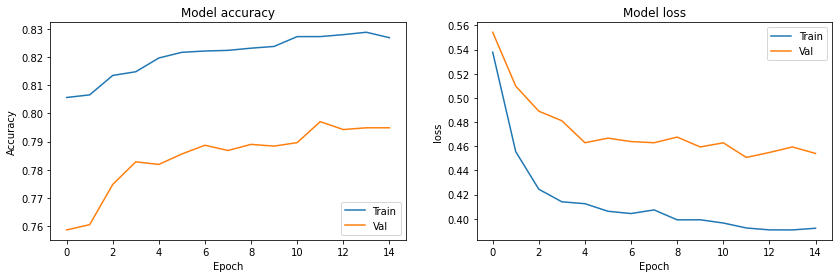

In [89]:
accuracy_loss_plot(history)


In [90]:
accr = model_embed.evaluate(X_test,y_test)
print('Test set\n  Loss for model embed: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

127/127 [==============================] - 5s 12ms/step - loss: 0.3890 - accuracy: 0.8310
Test set
  Loss for model embed: 0.389
  Accuracy: 0.831


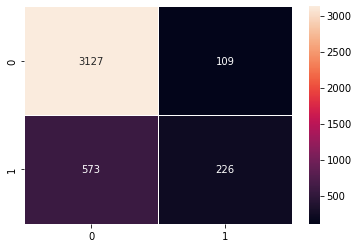

In [91]:
#evaluate
import seaborn as sns
from sklearn.metrics import confusion_matrix

#convert probabilistic output to binary
y_pred = (model_embed.predict(X_test) > 0.5).astype("int32")
#confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, linewidths = 1, fmt= 'g', annot=True);

In [92]:
#precision, recall, AUC, ROC Curve
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
accuracy = accuracy_score(y_test, y_pred)
metric = list(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print('Set Accuracy: \t', round(accuracy * 100, 2))
print('Set Precision: \t', round(metric[0], 2))
print('Set Recall: \t', round(metric[1], 2))
print('Set F score: \t', round(metric[2], 2))

Set Accuracy: 	 83.1
Set Precision: 	 0.76
Set Recall: 	 0.62
Set F score: 	 0.65


In [93]:
model_embed.save('models/lstm_skill_extractor.h5')
